OrderedDict()
Epoch 1, Loss: 2.3616
Epoch 2, Loss: 2.9617
Epoch 3, Loss: 1.4438
Epoch 4, Loss: 1.5431
Epoch 5, Loss: 0.9290
Epoch 6, Loss: 1.0538
Epoch 7, Loss: 0.6321
Epoch 8, Loss: 1.0895
Epoch 9, Loss: 1.0501
Epoch 10, Loss: 0.6652
Epoch 11, Loss: 0.6739
Epoch 12, Loss: 0.8467
Epoch 13, Loss: 0.7389
Epoch 14, Loss: 0.9026
Epoch 15, Loss: 1.1782
Epoch 16, Loss: 1.2417
Epoch 17, Loss: 0.8794
Epoch 18, Loss: 0.9453
Epoch 19, Loss: 1.2429
Epoch 20, Loss: 1.4250
Epoch 21, Loss: 0.8085
Epoch 22, Loss: 0.8812
Epoch 23, Loss: 0.6099
Epoch 24, Loss: 0.8783
Epoch 25, Loss: 1.1619
Epoch 26, Loss: 0.6589
Epoch 27, Loss: 0.9781
Epoch 28, Loss: 0.5579
Epoch 29, Loss: 1.2490
Epoch 30, Loss: 1.1303
Epoch 31, Loss: 1.0018
Epoch 32, Loss: 0.6969
Epoch 33, Loss: 0.9051
Epoch 34, Loss: 0.5275
Epoch 35, Loss: 0.7159
Epoch 36, Loss: 0.8159
Epoch 37, Loss: 0.8590
Epoch 38, Loss: 0.5181
Epoch 39, Loss: 0.5957
Epoch 40, Loss: 0.7749
Epoch 41, Loss: 0.6456
Epoch 42, Loss: 0.9630
Epoch 43, Loss: 1.0745
Epoch 

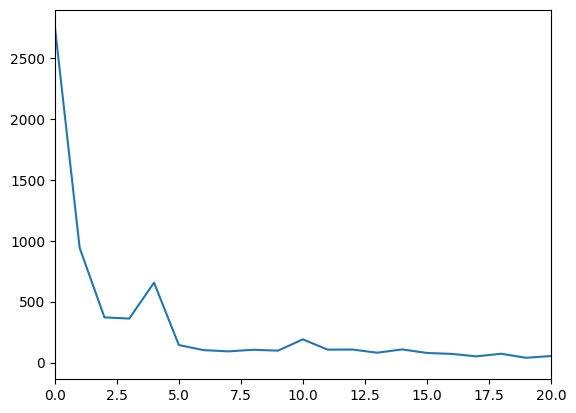

OrderedDict()
Mean Squared Error 0.722061834594076
Mean Absolute Error 0.6322864940924238


In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

dataset = fetch_california_housing()
x = dataset.data
y= dataset.target
y = y.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CaliforniaHousingDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]


trainDataset = CaliforniaHousingDataset(x_train, y_train)
testDataset = CaliforniaHousingDataset(x_test, y_test)

class ANNRegression(nn.Module):
    def __init__(self):
        super(ANNRegression, self).__init__()
        self.w1 = torch.randn(8, 64, requires_grad=True)
        self.b1 = torch.randn(64, requires_grad=True)

        self.w2 = torch.randn(64, 16, requires_grad=True)
        self.b2 = torch.randn(16, requires_grad=True)

        self.w3 = torch.randn(16, 8, requires_grad=True)
        self.b3 = torch.randn(8, requires_grad=True)

        self.w4 = torch.randn(8, 1, requires_grad=True)
        self.b4 = torch.randn(1, requires_grad=True)

    def forward(self, x):
        hiddenLayer1_Input = torch.matmul(x, self.w1) + self.b1
        hiddenLayer1_Output = torch.relu(hiddenLayer1_Input)

        hiddenLayer2_Input = torch.matmul(hiddenLayer1_Output, self.w2) + self.b2
        hiddenLayer2_Output = torch.relu(hiddenLayer2_Input)

        hiddenLayer3_Input = torch.matmul(hiddenLayer2_Output, self.w3) + self.b3
        hiddenLayer3_Output = torch.relu(hiddenLayer3_Input)

        output = torch.matmul(hiddenLayer3_Output, self.w4) + self.b4
        return output

def meanSquaredErrorLoss(y_true, y_pred):
    error = y_true-y_pred
    loss = torch.mean((error**2))
    return loss

def meanAbsoluteError(y_true, y_pred):
    error = y_true-y_pred
    loss = torch.mean(torch.abs(error))
    return loss

class SGDOptimizer:
    def __init__(self, parameters, lr):
        self.parameters = parameters
        self.lr = lr

    def step(self):
        for param in self.parameters:
            if param.grad is not None:
                param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad = None

def train_model(model, trainDataset, n_epoch, batchSize, loss_fn, optimizer):

    trainLoader = DataLoader(trainDataset, batch_size= batchSize, shuffle=True)
    losses = []
    for epoch in range(n_epoch):
        for x_train, y_train in trainLoader:
            model.train()
            x_train = x_train.to(device)
            y_train = y_train.to(device)

            ypred = model(x_train)
            loss = loss_fn(ypred, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return model, losses


def evaluate_model(model, testDataset, batchSize, maeloss, mseloss):
    testLoader = DataLoader(testDataset, batch_size=batchSize, shuffle=False)
    totalMae = 0
    totalMse = 0
    totalSamples = 0
    model.eval()

    with torch.no_grad():
        for x_test, y_test in testLoader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)

            ypred = model(x_test)
            mae = maeloss(y_test, ypred).item()
            mse = mseloss(y_test, ypred).item()

            totalMae += mae * len(y_test)
            totalMse += mse * len(y_test)
            totalSamples += len(y_test)

    meanAbsolute = totalMae / totalSamples
    meanSquared = totalMse / totalSamples

    return meanAbsolute , meanSquared



model = ANNRegression()
optimizer = SGDOptimizer([model.w1, model.b1, model.w2, model.b2, model.w3, model.b3 , model.w4, model.b4], lr=0.0001)
model , losses = train_model(model, trainDataset,n_epoch=100 , batchSize= 64, loss_fn= meanSquaredErrorLoss , optimizer=optimizer)
plt.plot(losses)
plt.xlim(0,20)
plt.show()


mae , mse = evaluate_model(model,testDataset, 64 , meanAbsoluteError , meanSquaredErrorLoss)
print('Mean Squared Error' , mse)
print("Mean Absolute Error" , mae)

